In [18]:
import torch
from torch.utils.data import DataLoader
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from torch.optim import AdamW
from datasets import load_dataset
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [19]:
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
# Load IMDB dataset (binary sentiment classification)
dataset = load_dataset("imdb")

In [21]:
# Display dataset details
print(f"Train Size: {len(dataset['train'])}, Test Size: {len(dataset['test'])}")
print("Example Positive Review:\n", dataset['train'][0]['text'][:500])
print("\nExample Negative Review:\n", dataset['train'][-1]['text'][:500])

Train Size: 25000, Test Size: 25000
Example Positive Review:
 I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attent

Example Negative Review:
 The story centers around Barry McKenzie who must go to England if he wishes to claim his inheritance. Being about the grossest Aussie shearer ever to set foot outside this great Nation of ours there is something of a culture clash and much fun and games ensue. The songs of Barry McKenzie(Barry Crocker) are highlights.


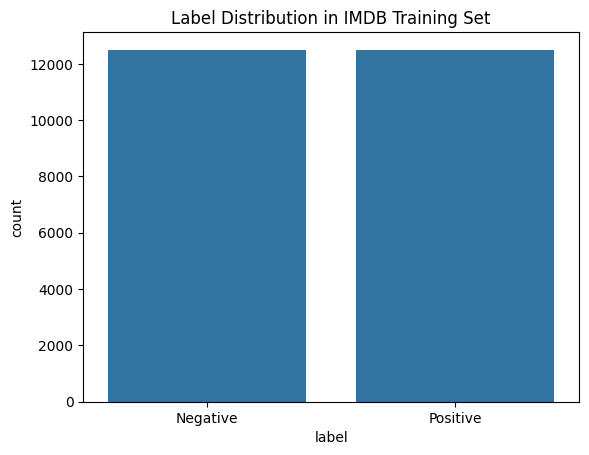

In [22]:
# Plot label distribution
labels = [example['label'] for example in dataset['train']]
label_df = pd.DataFrame(labels, columns=['label'])
label_df['label'] = label_df['label'].map({0: 'Negative', 1: 'Positive'})
sns.countplot(data=label_df, x='label')
plt.title("Label Distribution in IMDB Training Set")
plt.show()

Model

In [23]:
# Load tokenizer and model
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [24]:
# Tokenization function
def tokenize(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True, max_length=512)

tokenized_dataset = dataset.map(tokenize, batched=True)
tokenized_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [25]:
# Prepare DataLoaders
train_loader = DataLoader(tokenized_dataset['train'], batch_size=16, shuffle=True)
test_loader = DataLoader(tokenized_dataset['test'], batch_size=16)

In [26]:
# Optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

In [27]:
# Training Loop (1 epoch example)
model.train()
for batch in train_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['label'].to(device)

    outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs.loss
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    break

In [ ]:
# Evaluate model
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, axis=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


# Print metrics
print(classification_report(all_labels, all_preds, target_names=['Negative', 'Positive']))


In [ ]:
# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()